In [1]:
import os
user = os.getenv('USER')
import sys
sys.path.insert(0, f'/Home/{user}/py/stereoid')

In [2]:
import glob

import numpy as np
import matplotlib.pyplot as plt
import pyproj

import drama.utils as drtls
from drama.io import cfg as cfg
from drama.geo import SingleSwathBistatic

import stereoid.sar_performance as strsarperf
import stereoid.oceans.tools.observation_tools as obs_tools
from stereoid.sea_ice import FwdModel, SceneGenerator, RetrievalModel

from harmony23lib import *

In [3]:
# Run ID
mode = "IWS"
runid='2021_1_seaice'

# stereoid path
path=f'/data1/{user}/stereoid'
pardir=path + '/PAR/'
parfile=pardir + 'Hrmny_' + '2021_1_seaice' + '.cfg'
cfgdata = cfg.ConfigFile(drtls.get_par_file(parfile))
main_dir=path + ''

# input neXtSIM files
model_dir=path + '/nextsim/'

# radar model
#fstr_dual = strsarperf.sarperf_files(main_dir, rx_dual_name, mode=mode, runid=runid) # at the moment IW only I think
fstr_ati = strsarperf.sarperf_files(main_dir, 'tud_2020_tripple_ati', mode=mode, runid=runid)
fstr_s1 = strsarperf.sarperf_files(main_dir, 'sentinel', mode=mode, runid=runid, is_bistatic=False)

# some additional settings
x_res=cfgdata.sar.gr_res # is readily set 
y_res=cfgdata.sar.gr_res # make it equal to the monostatic ground-range resolution
t_res=cfgdata.orbit.timestep # along-track time resolution of generated swath
sp=[complex(1.6,0.07), 0.0030, 0.015, 0.04] 
ip=[complex(3.65,0.38), 0.0030, 0.015] 
pol='hh+hv'
prod_res = np.sqrt(x_res * y_res)
b_ati=10
t_orb=12/175

inc_m_deg=31.1
inc_m = np.deg2rad(inc_m_deg)
along_track_separation=375e3 # should be consistent with the PAR file
obs_geo = obs_tools.build_geometry(parfile, inc_m, dau=along_track_separation)

fwdm = FwdModel(parfile,sp,ip)# initialize forwaes model
sgm = SceneGenerator(fwdm,x_res,y_res,n_orbs=2) # initialize scene generator
proj = pyproj.proj.Proj('+proj=stere +lat_0=90 +lat_ts=75')
n_orbits = 4
n_swath = 3
figsize=(12,5)

In [4]:
# create Swath generator
swb = SingleSwathBistatic(par_file=parfile, dau=along_track_separation, n_orbits=n_orbits)
for i in range(n_swath):
    swth_bst = next(swb)
# create swath grids with X, Y in polar stereographic projection
x_sz, y_sz, nor_sz = create_swath_grids(swth_bst, proj, t_res, y_res)

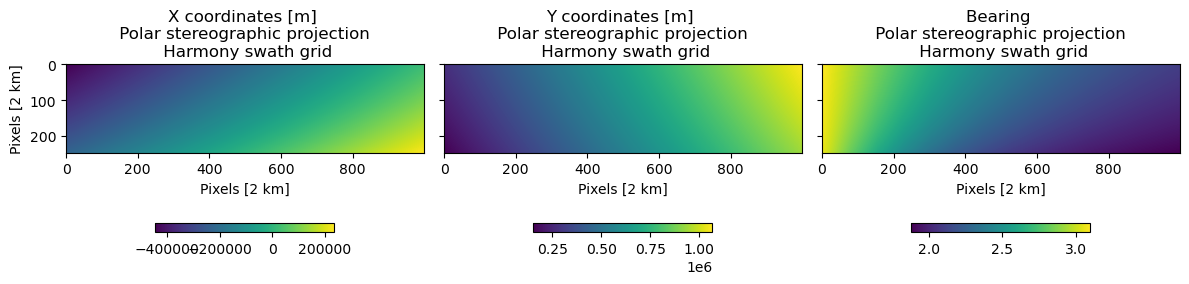

In [5]:
row0, row1 = 2620, 3620

fig, axs = plt.subplots(1,3, figsize=figsize, sharey=True)
imsh = axs[0].imshow(x_sz[row0:row1].T)
plt.colorbar(imsh, ax=axs[0], orientation='horizontal', shrink=0.5)
axs[0].set_title('X coordinates [m] \n Polar stereographic projection \n Harmony swath grid')
axs[0].set_ylabel('Pixels [2 km]')

imsh = axs[1].imshow(y_sz[row0:row1].T)
plt.colorbar(imsh, ax=axs[1], orientation='horizontal', shrink=0.5)
axs[1].set_title('Y coordinates [m] \n Polar stereographic projection \n Harmony swath grid')
imsh = axs[2].imshow(nor_sz[row0:row1].T)
plt.colorbar(imsh, ax=axs[2], orientation='horizontal', shrink=0.5)
axs[2].set_title('Bearing \n Polar stereographic projection \n Harmony swath grid')

for ax in axs:
    ax.set_xlabel('Pixels [2 km]')

plt.tight_layout()
plt.show()

In [6]:
# read coordinates of nodes, u, v and concentration and triangulation from nextsim mesh
# X, Y are in polar stereographic projection
filename = f'/data1/{user}/stereoid/nextsim/sa05_2019_exp_00/field_20190101T060000Z.npz'
x, y, v_e, v_n, c, t = read_nextsim_data(filename, proj, lon_0=0)

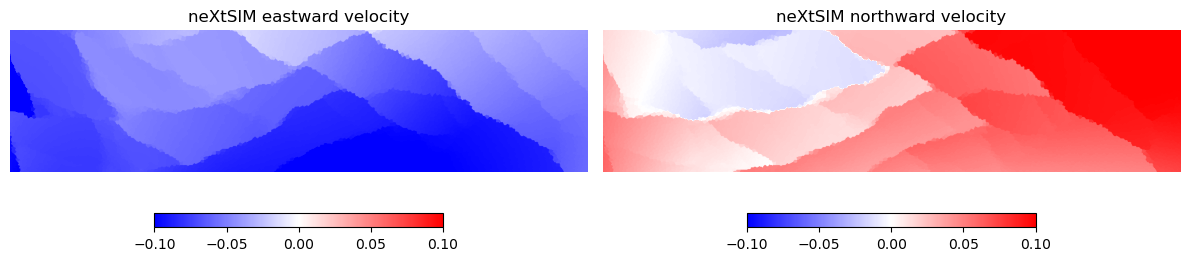

In [7]:
# Create grids with neXtSIM U, V, landmask and ice mask in SWATH projection
v_e_sz, v_n_sz, landmask, icemask = interpolate_nextsim_on_swath(x, y, v_e, v_n, c, t, x_sz, y_sz)

v_e_sz[icemask.mask] = np.nan
v_n_sz[icemask.mask] = np.nan

vmax = 0.1
fig, axs = plt.subplots(1,2, figsize=(12,3))
imsh = axs[0].imshow(v_e_sz[row0:row1].T, cmap='bwr', clim=[-vmax,vmax])
plt.colorbar(imsh, ax=axs[0], orientation='horizontal', shrink=0.5)
imsh = axs[1].imshow(v_n_sz[row0:row1].T, cmap='bwr', clim=[-vmax,vmax])
plt.colorbar(imsh, ax=axs[1], orientation='horizontal', shrink=0.5)

axs[0].set_title('neXtSIM eastward velocity')
axs[1].set_title('neXtSIM northward velocity')
for ax in axs:
    ax.set_axis_off()

plt.tight_layout()
plt.show()

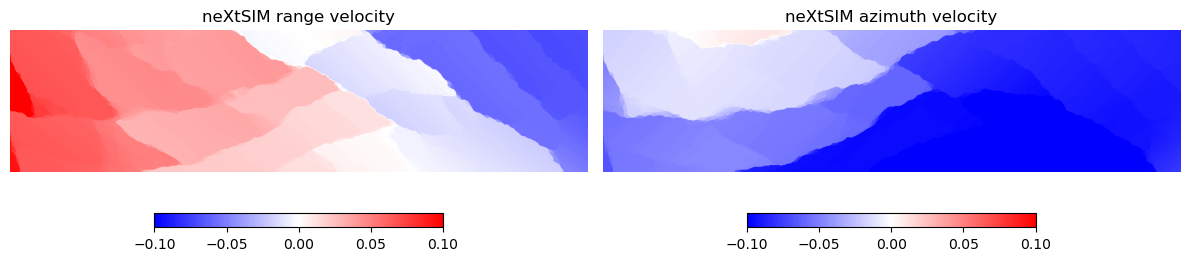

In [8]:
# Compute range and azimuth components of U and V
u_int, v_int = compute_nextsim_uv(v_e_sz, v_n_sz, landmask, nor_sz)

fig, axs = plt.subplots(1,2, figsize=(12,3))
imsh = axs[0].imshow(u_int[row0:row1].T, cmap='bwr', clim=[-vmax,vmax])
plt.colorbar(imsh, ax=axs[0], orientation='horizontal', shrink=0.5)
imsh = axs[1].imshow(v_int[row0:row1].T, cmap='bwr', clim=[-vmax,vmax])
plt.colorbar(imsh, ax=axs[1], orientation='horizontal', shrink=0.5)

axs[0].set_title('neXtSIM range velocity')
axs[1].set_title('neXtSIM azimuth velocity')
for ax in axs:
    ax.set_axis_off()

plt.tight_layout()

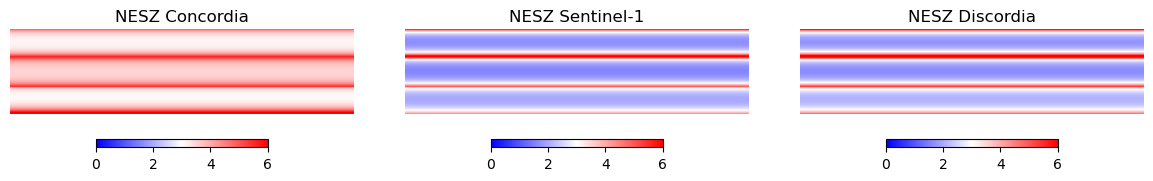

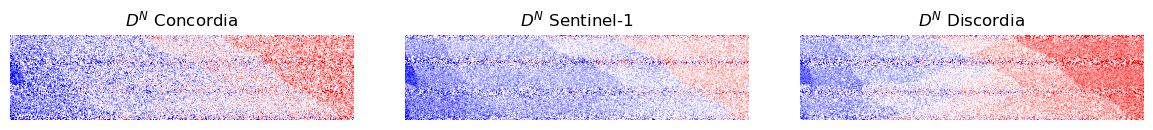

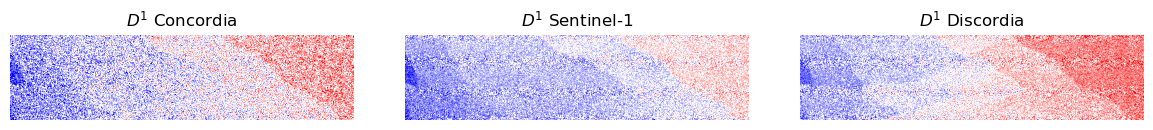

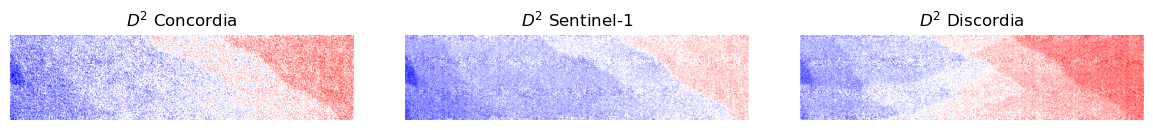

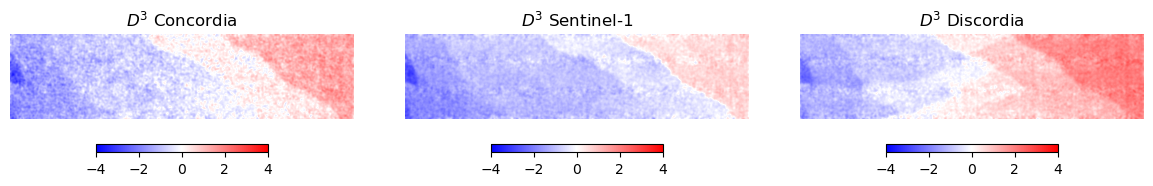

In [9]:
figsize=(12,2)

dopp, s_dopp, r_dopp_r0 = get_doppler(sgm, obs_geo, u_int, v_int, x_res, pol, inc_m, fstr_s1, fstr_ati, prod_res, b_ati)
r_dopp_d0 = remove_texture_noise(r_dopp_r0, s_dopp)
r_dopp_mk = np.zeros_like(r_dopp_r0[row0:row1])
r_dopp_ad = np.zeros_like(r_dopp_r0[row0:row1])
for i in range(3):
    r_dopp_mk[:,:,i] = denoise_mk(dopp[row0:row1,:,i], r_dopp_d0[row0:row1,:,i])
    r_dopp_ad[:,:,i] = apply_anisotropic_diffusion(r_dopp_mk[:,:,i], kappa=5)

vmax = 6
fig, axs = plt.subplots(1,3, figsize=figsize)
imsh = axs[0].imshow(s_dopp[row0:row1,:,0].T, cmap='bwr', clim=[0,vmax])
plt.colorbar(imsh, ax=axs[0], orientation='horizontal', shrink=0.5)
imsh = axs[1].imshow(s_dopp[row0:row1,:,1].T, cmap='bwr', clim=[0,vmax])
plt.colorbar(imsh, ax=axs[1], orientation='horizontal', shrink=0.5)
imsh = axs[2].imshow(s_dopp[row0:row1,:,2].T, cmap='bwr', clim=[0,vmax])
plt.colorbar(imsh, ax=axs[2], orientation='horizontal', shrink=0.5)
plt.tight_layout()

axs[0].set_title('NESZ Concordia')
axs[1].set_title('NESZ Sentinel-1')
axs[2].set_title('NESZ Discordia')
for ax in axs:
    ax.set_axis_off()
plt.show()

vmax = 4
fig, axs = plt.subplots(1,3, figsize=figsize)
imsh = axs[0].imshow(r_dopp_r0[row0:row1,:,0].T, cmap='bwr', clim=[-vmax,vmax])
imsh = axs[1].imshow(r_dopp_r0[row0:row1,:,1].T, cmap='bwr', clim=[-vmax,vmax])
imsh = axs[2].imshow(r_dopp_r0[row0:row1,:,2].T, cmap='bwr', clim=[-vmax,vmax])
plt.tight_layout()

axs[0].set_title('$D^N$ Concordia')
axs[1].set_title('$D^N$ Sentinel-1')
axs[2].set_title('$D^N$ Discordia')
for ax in axs:
    ax.set_axis_off()
plt.show()

fig, axs = plt.subplots(1,3, figsize=figsize)
imsh = axs[0].imshow(r_dopp_d0[row0:row1,:,0].T, cmap='bwr', clim=[-vmax,vmax])
imsh = axs[1].imshow(r_dopp_d0[row0:row1,:,1].T, cmap='bwr', clim=[-vmax,vmax])
imsh = axs[2].imshow(r_dopp_d0[row0:row1,:,2].T, cmap='bwr', clim=[-vmax,vmax])
plt.tight_layout()

axs[0].set_title('$D^1$ Concordia')
axs[1].set_title('$D^1$ Sentinel-1')
axs[2].set_title('$D^1$ Discordia')
for ax in axs:
    ax.set_axis_off()
plt.show()

fig, axs = plt.subplots(1,3, figsize=figsize)
imsh = axs[0].imshow(r_dopp_mk[:,:,0].T, cmap='bwr', clim=[-vmax,vmax])
imsh = axs[1].imshow(r_dopp_mk[:,:,1].T, cmap='bwr', clim=[-vmax,vmax])
imsh = axs[2].imshow(r_dopp_mk[:,:,2].T, cmap='bwr', clim=[-vmax,vmax])
plt.tight_layout()

axs[0].set_title('$D^2$ Concordia')
axs[1].set_title('$D^2$ Sentinel-1')
axs[2].set_title('$D^2$ Discordia')
for ax in axs:
    ax.set_axis_off()
plt.show()

fig, axs = plt.subplots(1,3, figsize=figsize)
imsh = axs[0].imshow(r_dopp_ad[:,:,0].T, cmap='bwr', clim=[-vmax,vmax])
plt.colorbar(imsh, ax=axs[0], orientation='horizontal', shrink=0.5)
imsh = axs[1].imshow(r_dopp_ad[:,:,1].T, cmap='bwr', clim=[-vmax,vmax])
plt.colorbar(imsh, ax=axs[1], orientation='horizontal', shrink=0.5)
imsh = axs[2].imshow(r_dopp_ad[:,:,2].T, cmap='bwr', clim=[-vmax,vmax])
plt.colorbar(imsh, ax=axs[2], orientation='horizontal', shrink=0.5)
plt.tight_layout()

axs[0].set_title('$D^3$ Concordia')
axs[1].set_title('$D^3$ Sentinel-1')
axs[2].set_title('$D^3$ Discordia')
for ax in axs:
    ax.set_axis_off()
plt.show()


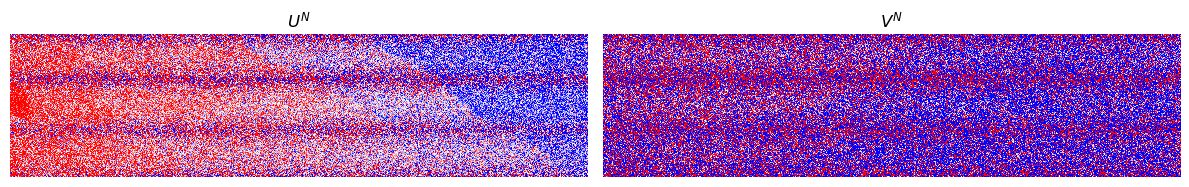

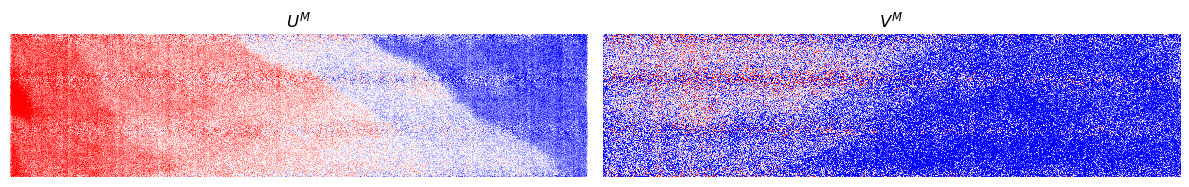

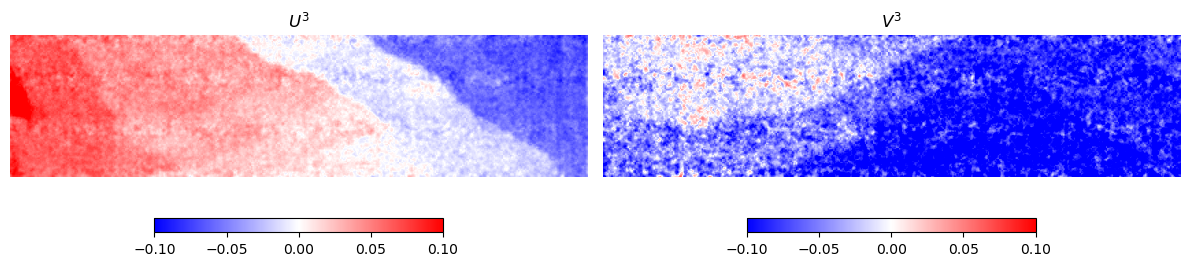

In [10]:
retrievalm = RetrievalModel(obs_geo.concordia, obs_geo.discordia, parfile)
uv_r0 = retrievalm.sea_ice_drift(np.array(r_dopp_r0[row0:row1]))
um = denoise_mk(u_int[row0:row1], uv_r0[:,:,0], 1)
vm = denoise_mk(v_int[row0:row1], uv_r0[:,:,1], 1)
uv_ad = retrievalm.sea_ice_drift(np.array(r_dopp_ad))

figsize = 12, 3
vmax = 0.1
fig, axs = plt.subplots(1,2, figsize=figsize)
imsh = axs[0].imshow(uv_r0[:,:,0].T, cmap='bwr', clim=[-vmax,vmax], interpolation='nearest')
imsh = axs[1].imshow(uv_r0[:,:,1].T, cmap='bwr', clim=[-vmax,vmax], interpolation='nearest')

axs[0].set_title('$U^N$')
axs[1].set_title('$V^N$')
for ax in axs:
    ax.set_axis_off()

plt.tight_layout()
plt.show()

fig, axs = plt.subplots(1,2, figsize=figsize)
imsh = axs[0].imshow(um.T, cmap='bwr', clim=[-vmax,vmax], interpolation='nearest')
imsh = axs[1].imshow(vm.T, cmap='bwr', clim=[-vmax,vmax], interpolation='nearest')

axs[0].set_title('$U^M$')
axs[1].set_title('$V^M$')
for ax in axs:
    ax.set_axis_off()

plt.tight_layout()    
plt.show()

fig, axs = plt.subplots(1,2, figsize=figsize)
imsh0 = axs[0].imshow(uv_ad[:,:,0].T, cmap='bwr', clim=[-vmax,vmax], interpolation='nearest')
imsh1 = axs[1].imshow(uv_ad[:,:,1].T, cmap='bwr', clim=[-vmax,vmax], interpolation='nearest')

plt.colorbar(imsh, ax=axs[0], orientation='horizontal', shrink=0.5)
plt.colorbar(imsh, ax=axs[1], orientation='horizontal', shrink=0.5)

axs[0].set_title('$U^3$')
axs[1].set_title('$V^3$')
for ax in axs:
    ax.set_axis_off()

plt.tight_layout()    
plt.show()


In [11]:
ui = u_int[row0:row1]
vi = v_int[row0:row1]
ua = uv_ad[:,:,0]
va = uv_ad[:,:,1]
np.savez('velocities.npz', ui=ui, vi=vi, ua=ua, va=va)

n_clusters_tot 16


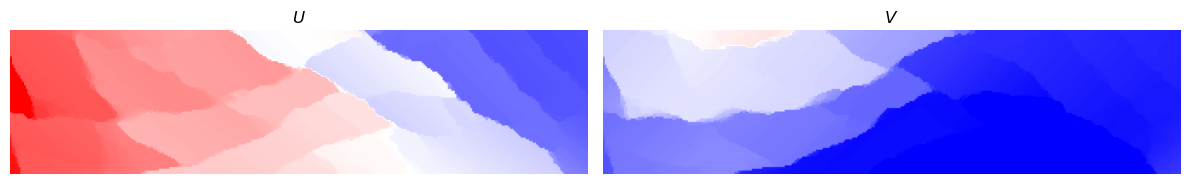

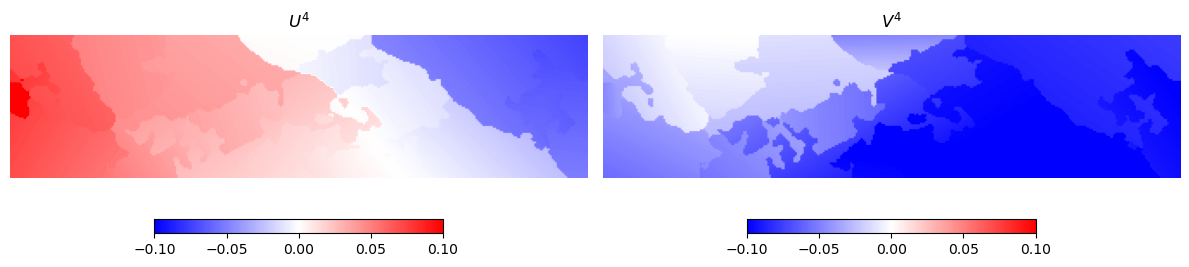

In [12]:
stp = 3

# AK
uz = multi_look(ua, stp)
vz = multi_look(va, stp)
uc, vc = clustering_filter(uz, vz, n_clusters=50, med_filt_size=5, xy_interpolation=True)

vmax = 0.1
fig, axs = plt.subplots(1,2, figsize=figsize)
imsh = axs[0].imshow(ui[::stp, ::stp].T, cmap='bwr', clim=[-vmax,vmax])
imsh = axs[1].imshow(vi[::stp, ::stp].T, cmap='bwr', clim=[-vmax,vmax])

axs[0].set_title('$U$')
axs[1].set_title('$V$')
for ax in axs:
    ax.set_axis_off()
plt.tight_layout()
plt.show()

fig, axs = plt.subplots(1,2, figsize=figsize)
imsh = axs[0].imshow(uc.T, cmap='bwr', clim=[-vmax,vmax])
plt.colorbar(imsh, ax=axs[0], orientation='horizontal', shrink=0.5)
imsh = axs[1].imshow(vc.T, cmap='bwr', clim=[-vmax,vmax])
plt.colorbar(imsh, ax=axs[1], orientation='horizontal', shrink=0.5)
axs[0].set_title('$U^4$')
axs[1].set_title('$V^4$')
for ax in axs:
    ax.set_axis_off()
plt.tight_layout()
plt.show()


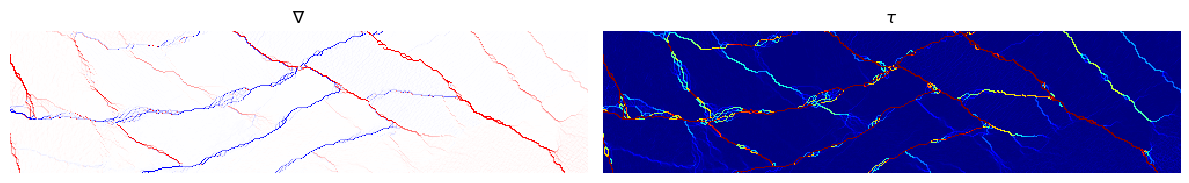

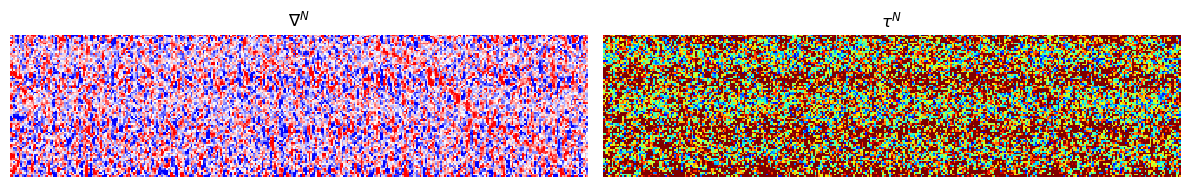

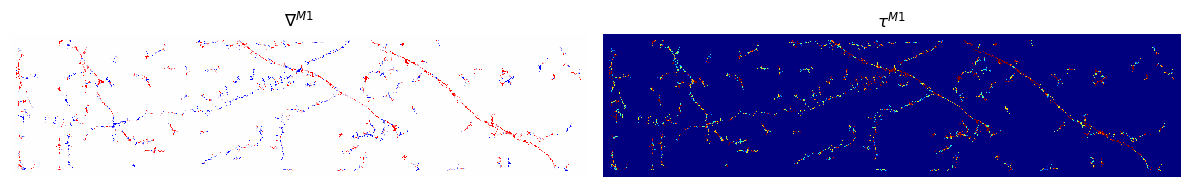

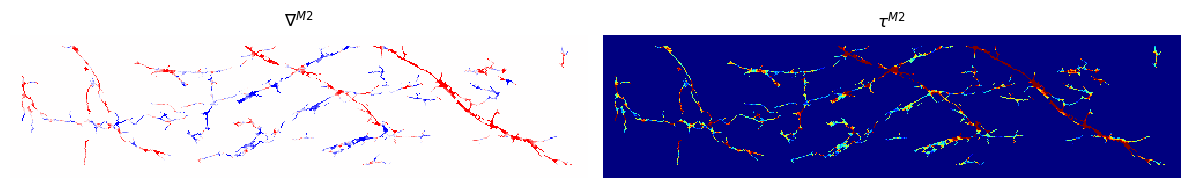

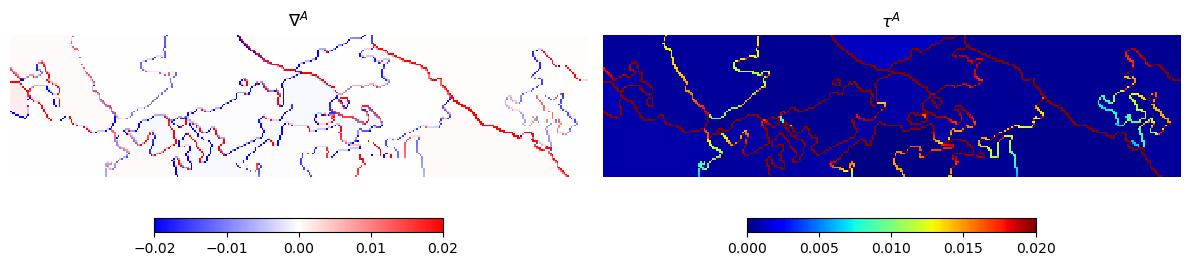

In [13]:
stp = 2

divi, shei, toti = get_deformation(ui[::stp, ::stp], vi[::stp, ::stp])

# RAW
divz, shez, totz = get_deformation(uz, vz)

# MK1
divm1, shem1, totm1 = get_deformaion_from_uv_mk(um, vm)

# MK2
divm2, shem2, totm2 = get_deformaion_from_uv_mk2(um, vm, stp=stp)

# AK
divc, shec, totc = get_deformation(uc, vc)

vmax = 0.02
iii='nearest'
fig, axs = plt.subplots(1,2, figsize=figsize)
imsh = axs[0].imshow(divi.T, cmap='bwr', clim=[-vmax,vmax], interpolation=iii)
imsh = axs[1].imshow(shei.T, cmap='jet', clim=[0,vmax], interpolation=iii)
axs[0].set_title(r'$\nabla$')
axs[1].set_title(r'$\tau$')
for ax in axs:
    ax.set_axis_off()
plt.tight_layout()
plt.show()

fig, axs = plt.subplots(1,2, figsize=figsize)
imsh = axs[0].imshow(divz.T, cmap='bwr', clim=[-vmax,vmax], interpolation=iii)
imsh = axs[1].imshow(shez.T, cmap='jet', clim=[0,vmax], interpolation=iii)
axs[0].set_title(r'$\nabla^N$')
axs[1].set_title(r'$\tau^N$')
for ax in axs:
    ax.set_axis_off()
plt.tight_layout()
plt.show()

fig, axs = plt.subplots(1,2, figsize=figsize)
imsh = axs[0].imshow(divm1.T, cmap='bwr', clim=[-vmax,vmax], interpolation=iii)
imsh = axs[1].imshow(shem1.T, cmap='jet', clim=[0,vmax], interpolation=iii)
axs[0].set_title(r'$\nabla^{M1}$')
axs[1].set_title(r'$\tau^{M1}$')
for ax in axs:
    ax.set_axis_off()
plt.tight_layout()
plt.show()

fig, axs = plt.subplots(1,2, figsize=figsize)
imsh = axs[0].imshow(divm2.T, cmap='bwr', clim=[-vmax,vmax], interpolation=iii)
imsh = axs[1].imshow(shem2.T, cmap='jet', clim=[0,vmax], interpolation=iii)
axs[0].set_title(r'$\nabla^{M2}$')
axs[1].set_title(r'$\tau^{M2}$')
for ax in axs:
    ax.set_axis_off()
plt.tight_layout()
plt.show()

fig, axs = plt.subplots(1,2, figsize=figsize)
imsh = axs[0].imshow(divc.T, cmap='bwr', clim=[-vmax,vmax], interpolation=iii)
plt.colorbar(imsh, ax=axs[0], orientation='horizontal', shrink=0.5)
imsh = axs[1].imshow(shec.T, cmap='jet', clim=[0,vmax], interpolation=iii)
plt.colorbar(imsh, ax=axs[1], orientation='horizontal', shrink=0.5)
axs[0].set_title(r'$\nabla^{A}$')
axs[1].set_title(r'$\tau^{A}$')
for ax in axs:
    ax.set_axis_off()
plt.tight_layout()
plt.show()
